In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

In [7]:
df = pd.read_csv("D:\DATA\Iris.csv")
df.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [8]:
df = df.copy()
df.fillna(method='ffill', inplace=True)
# determine target column
target_col = 'species' if 'species' in df.columns else df.columns[-1]
# encode target if categorical
if df[target_col].dtype == 'object':
    le = LabelEncoder()
    df[target_col] = le.fit_transform(df[target_col])
# features and target
X = df.drop(columns=[target_col])
y = df[target_col]
# scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape

((120, 4), (30, 4))

In [9]:
# baseline Logistic Regression
lr = LogisticRegression(max_iter=200)
lr.fit(X_train, y_train)
# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
models_baseline = {'LogisticRegression': lr, 'DecisionTree': dt, 'RandomForest': rf}

LogisticRegression accuracy: 0.9333


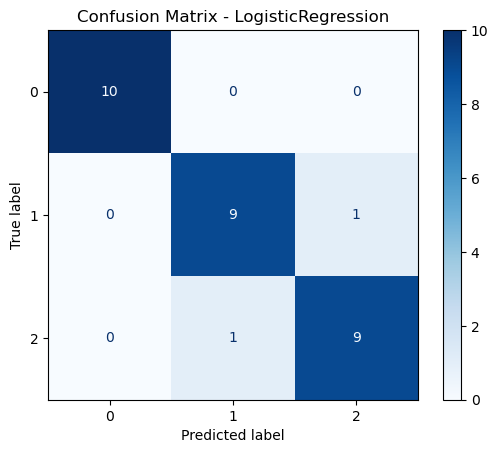

DecisionTree accuracy: 0.9333


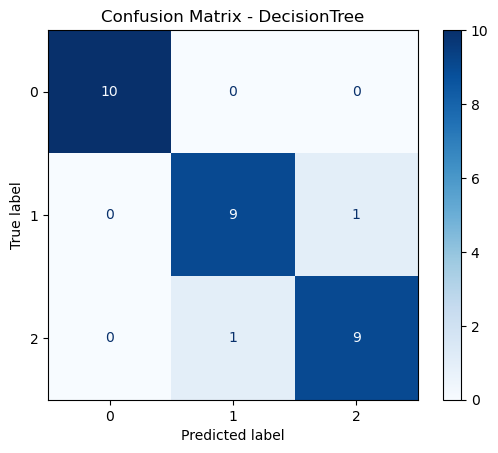

RandomForest accuracy: 0.9333


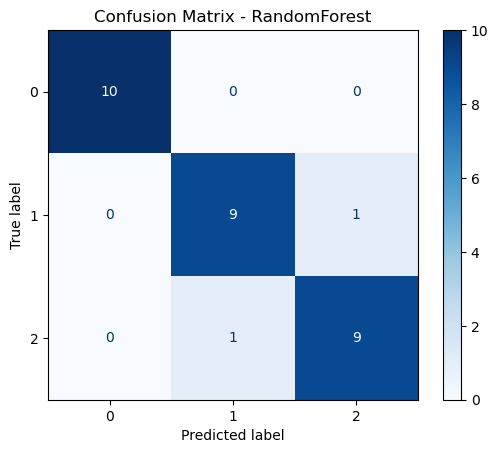

In [10]:
results = []
for name, model in models_baseline.items():
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    cm = confusion_matrix(y_test, preds)
    results.append({'model': name, 'metric': 'accuracy', 'before_tuning': acc, 'after_tuning': None})
    print(name + ' accuracy:', round(acc,4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

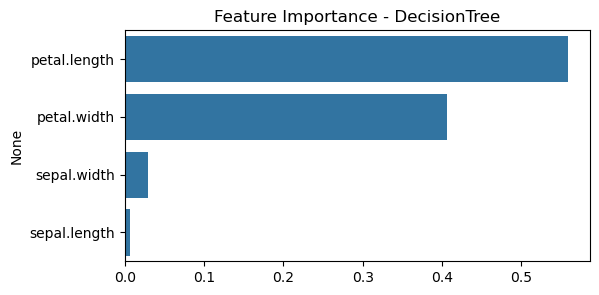

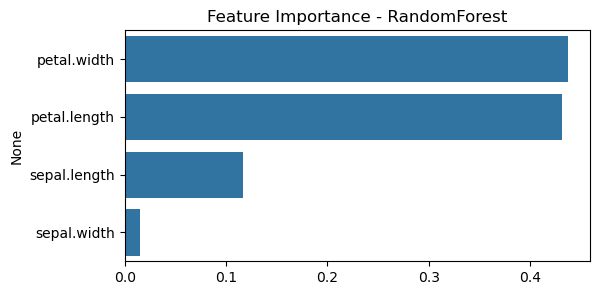

In [11]:
# feature importance for tree-based models
feature_names = X.columns.tolist()
for name in ['DecisionTree', 'RandomForest']:
    model = models_baseline[name]
    importances = model.feature_importances_
    fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    plt.figure(figsize=(6,3))
    sns.barplot(x=fi.values, y=fi.index)
    plt.title(f'Feature Importance - {name}')
    plt.show()

In [12]:
# Decision Tree grid
dt_param_grid = {'max_depth':[None,2,3,4,5], 'min_samples_split':[2,4,6]}
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_param_grid, cv=5, n_jobs=-1)
dt_grid.fit(X_train, y_train)
# Random Forest grid
rf_param_grid = {'n_estimators':[50,100,200], 'max_depth':[None,3,5], 'min_samples_split':[2,4]}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, n_jobs=-1)
rf_grid.fit(X_train, y_train)
# show best params
print('DT best params:', dt_grid.best_params_)
print('RF best params:', rf_grid.best_params_)

DT best params: {'max_depth': None, 'min_samples_split': 2}
RF best params: {'max_depth': 3, 'min_samples_split': 4, 'n_estimators': 100}


DecisionTree after tuning accuracy: 0.9333


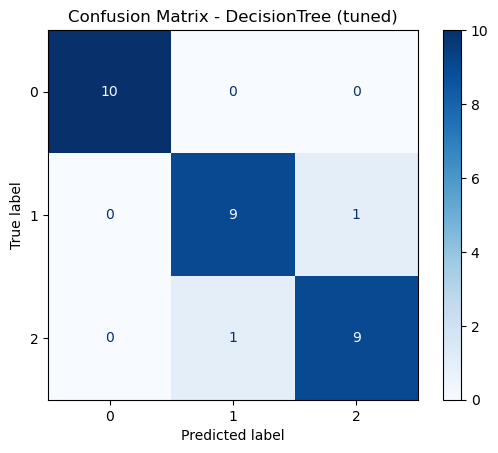

RandomForest after tuning accuracy: 0.9667


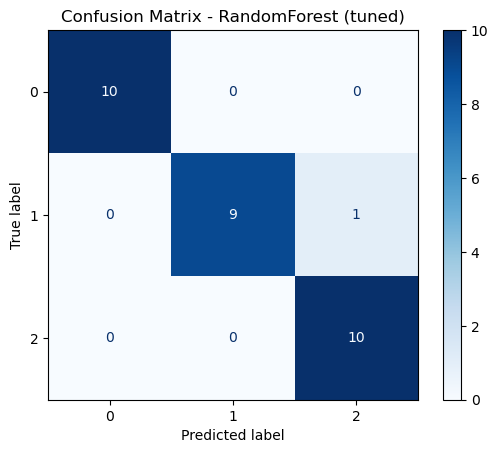

In [13]:
dt_tuned = DecisionTreeClassifier(**dt_grid.best_params_, random_state=42)
dt_tuned.fit(X_train, y_train)
rf_tuned = RandomForestClassifier(**rf_grid.best_params_, random_state=42)
rf_tuned.fit(X_train, y_train)
for name, model in [('DecisionTree', dt_tuned), ('RandomForest', rf_tuned)]:
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    for r in results:
        if r['model'] == name:
            r['after_tuning'] = acc
    print(name + ' after tuning accuracy:', round(acc,4))
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {name} (tuned)')
    plt.show()


In [14]:
comp_df = pd.DataFrame(results)
# Logistic Regression not tuned here; set after_tuning = before_tuning
comp_df.loc[comp_df['model']=='LogisticRegression','after_tuning'] = comp_df.loc[comp_df['model']=='LogisticRegression','before_tuning']
comp_df[['model','metric','before_tuning','after_tuning']]


,model,metric,before_tuning,after_tuning
0,LogisticRegression,accuracy,0.933333,0.933333
1,DecisionTree,accuracy,0.933333,0.933333
2,RandomForest,accuracy,0.933333,0.966667
